In [1]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

In [2]:
def _pos_encoding(t, output_dim, device='cpu'):
  D = output_dim
  v = torch.zeros(D, device=device)

  i = torch.arange(0, D, device=device)
  # div_term = 10000 ** (i / D)
  div_term = torch.exp(i / D * math.log(10000))

  v[0::2] = torch.sin(t / div_term[0::2])
  v[1::2] = torch.cos(t / div_term[1::2])
  return v

In [3]:
def pos_encoding(ts, output_dim, device='cpu'):
  batch_size = len(ts)
  v = torch.zeros(batch_size, output_dim, device=device)
  for i in range(batch_size):
    v[i] = _pos_encoding(ts[i], output_dim, device=device)
  return v

In [4]:
class ConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, time_embed_dim):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU()
    )
    self.mlp = nn.Sequential(
        nn.Linear(time_embed_dim, in_ch),
        nn.ReLU(),
        nn.Linear(in_ch, in_ch)
    )

  def forward(self, x, v):
    N, C, _, _ = x.shape
    v = self.mlp(v)
    v = v.view(N, C, 1, 1)
    y = self.convs(x + v)
    return y

In [5]:
class UNetCond(nn.Module):
  def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
    super().__init__()
    self.time_embed_dim = time_embed_dim

    self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
    self.down2 = ConvBlock(64, 128, time_embed_dim)
    self.bot1 = ConvBlock(128, 256, time_embed_dim)
    self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
    self.up1 = ConvBlock(64 + 128, 64, time_embed_dim)
    self.out = nn.Conv2d(64, in_ch, 1)

    self.maxpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    if num_labels is not None:
      self.label_emb = nn.Embedding(num_labels, time_embed_dim)

  def forward(self, x, timesteps, labels=None):
    t = pos_encoding(timesteps, self.time_embed_dim, x.device)

    if labels is not None:
      t + self.label_emb(labels)  # labels 인수가 주어졌을 때만 실행

    x1 = self.down1(x, t)
    x = self.maxpool(x1)
    x2 = self.down2(x, t)
    x = self.maxpool(x2)

    x = self.bot1(x, t)

    x = self.upsample(x)
    x = torch.cat([x, x2], dim=1)
    x = self.up2(x, t)
    x = self.upsample(x)
    x = torch.cat([x, x1], dim=1)
    x = self.up1(x, t)
    x = self.out(x)
    return x

In [6]:
class Diffuser:
  def __init__(self,
               num_timesteps=1000,
               beta_start=0.0001,
               beta_end=0.02,
               gamma=4.0,
               device='cpu'):
    self.num_timesteps = num_timesteps
    self.gamma = gamma
    self.device = device
    self.betas = torch.linspace(beta_start,
                                beta_end,
                                num_timesteps,
                                device=device)
    self.alphas = 1 - self.betas
    self.alpha_bars = torch.cumprod(self.alphas, dim=0)

  def add_noise(self, x_0, t):
    T = self.num_timesteps
    assert (t >= 1).all() and (t <= T).all()

    t_idx = t - 1
    alpha_bar = self.alpha_bars[t_idx]
    N = alpha_bar.size(0)
    alpha_bar = alpha_bar.view(N, 1, 1, 1)

    noise = torch.randn_like(x_0, device=self.device)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
    return x_t, noise

  def denoise(self, model, x, t, labels, gamma):
    T = self.num_timesteps
    assert (t >= 1).all() and (t <= T).all()

    t_idx = t - 1
    alpha = self.alphas[t_idx]
    alpha_bar = self.alpha_bars[t_idx]
    alpha_bar_prev = self.alpha_bars[t_idx-1]

    N = alpha.size(0)
    alpha = alpha.view(N, 1, 1, 1)
    alpha_bar = alpha_bar.view(N, 1, 1, 1)
    alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

    model.eval()
    with torch.no_grad():
      # eps = model(x, t, labels)
      eps_cond = model(x, t, labels)
      eps_uncond = model(x, t)
      eps = eps_uncond + gamma * (eps_cond - eps_uncond)
    model.train()

    noise = torch.randn_like(x, device=self.device)
    noise[t == 1] = 0

    mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
    std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
    return mu + noise * std

  def reverse_to_img(self, x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    x = x.cpu()
    to_pil = transforms.ToPILImage()
    return to_pil(x)

  def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
    batch_size = x_shape[0]
    x = torch.randn(x_shape, device=self.device)

    if labels is None:
      labels = torch.randint(0, 10, (len(x),), device=self.device)

    for i in tqdm(range(self.num_timesteps, 0, -1)):
      t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
      x = self.denoise(model, x, t, labels, self.gamma)
    images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
    return images, labels

In [7]:
def show_images(image, rows=2, cols=10, labels=None):
  fig = plt.figure(figsize=(cols, rows))
  i = 0
  for r in range(rows):
    for c in range(cols):
      ax = fig.add_subplot(rows, cols, i + 1)
      plt.imshow(image[i], cmap='gray')
      if labels is not None:
        ax.set_xlabel(labels[i].item())
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])
      i += 1
  plt.tight_layout()
  plt.show()

In [8]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/DLFS5/data',
                                    download=True,
                                    transform=preprocess)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [10]:
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [11]:
losses = []
for epoch in range(epochs):
  loss_sum = 0.0
  cnt = 0

  # images, labels = diffuser.sample(model)
  # show_images(images, labels=labels)

  for images, labels in tqdm(dataloader):
    optimizer.zero_grad()
    x = images.to(device)
    labels = labels.to(device)
    t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

    # 10% 확률로 '조건 없이' 학습
    if np.random.random() < 0.1:
      labels = None

    x_noisy, noise = diffuser.add_noise(x, t)
    noise_pred = model(x_noisy, t, labels)
    loss = F.mse_loss(noise, noise_pred)

    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    cnt += 1

  loss_avg = loss_sum / cnt
  losses.append(loss_avg)
  print(f'Epoch {epoch} | Loss: {loss_avg}')

100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 0 | Loss: 0.04458437574062266


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 1 | Loss: 0.025754754274670503


100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Epoch 2 | Loss: 0.02316423975574627


100%|██████████| 469/469 [00:55<00:00,  8.50it/s]


Epoch 3 | Loss: 0.021439442216460384


100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Epoch 4 | Loss: 0.020543777622155417


100%|██████████| 469/469 [00:55<00:00,  8.43it/s]


Epoch 5 | Loss: 0.01964310404143608


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch 6 | Loss: 0.019134292468380953


100%|██████████| 469/469 [00:55<00:00,  8.48it/s]


Epoch 7 | Loss: 0.01946528461465894


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch 8 | Loss: 0.018592823249127057


100%|██████████| 469/469 [00:55<00:00,  8.43it/s]

Epoch 9 | Loss: 0.01796178222854318


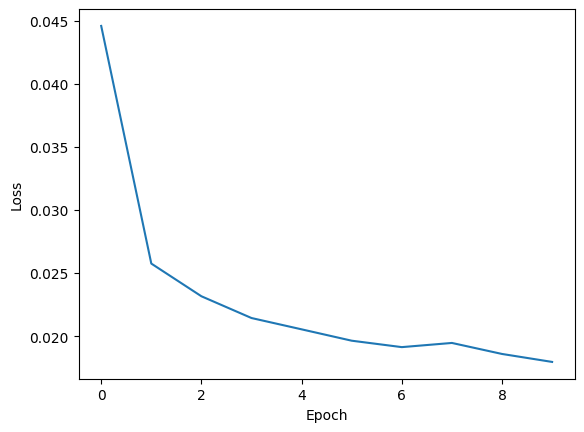

In [14]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

100%|██████████| 1000/1000 [00:17<00:00, 58.56it/s]


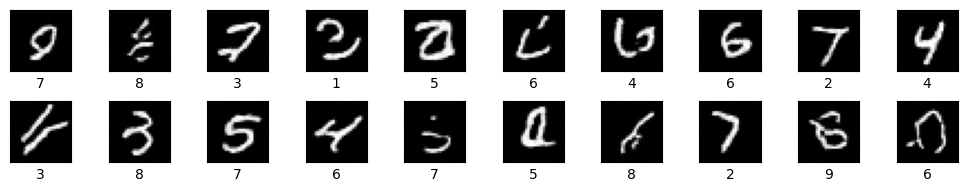

In [15]:
images, labels = diffuser.sample(model)
show_images(images, labels=labels)